# Intro

The primary aim of this analysis is to highlight the key factors that contributed to confirmation of Covid-19 cases in the United States of America. We will test a number of models including: Linear Regression, Lasso, Ridge, ElasticNet, Random Forest and Personal Component Regression and focus on the model that performs the best. The goal is to create a model that can be used to predict future Covid-19 cases and cases of a future disease of similar magnitude. 

# DATA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 3000
import warnings; warnings.simplefilter('ignore')

# EDA

### Open Data (Merged Open Data w/ Policy and Mobility Datasets)

In [2]:
open_data = pd.read_csv('clean_covid.csv')

In [3]:
open_data.drop(columns = ['Unnamed: 0'], inplace=True)
open_data.head()

state        date  retail_and_recreation_percent_change_from_baseline  \
0  Alabama  2020-02-15                                                5.0    
1  Alabama  2020-02-16                                                0.0    
2  Alabama  2020-02-17                                                3.0    
3  Alabama  2020-02-18                                               -4.0    
4  Alabama  2020-02-19                                                4.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                2.0   
1                                               -2.0   
2                                                0.0   
3                                               -3.0   
4                                                1.0   

   parks_percent_change_from_baseline  \
0                                39.0   
1                                -7.0   
2                                17.0   
3                               -11.0   
4                                 6.0   

   transit_stations_percent_change_from_baseline  \
0                                            7.0   
1                                            3.0   
2                                            7.0   
3                                           -1.0   
4                                            4.0   

   workplaces_percent_change_from_baseline  \
0                                      2.0   
1                                     -1.0   
2                                    -17.0   
3                                      1.0   
4                                      1.0   

   residential_percent_change_from_baseline  aggregation_level  \
0                                      -1.0                  1   
1                                       1.0                  1   
2                                       4.0                  1   
3                                       2.0                  1   
4                                       0.0                  1   

   average_temperature_celsius  minimum_temperature_celsius  \
0                     5.916667                    -1.800000   
1                     9.200000                     5.022222   
2                    11.672222                     8.422222   
3                    16.155556                    13.161111   
4                    14.644444                    11.455556   

   maximum_temperature_celsius  rainfall_mm  school_closing  \
0                    15.622222     0.000000             0.0   
1                    13.350000     0.987778             0.0   
2                    16.572222     2.057400             0.0   
3                    21.672222    14.421556             0.0   
4                    20.588889    32.370889             0.0   

   workplace_closing  cancel_public_events  restrictions_on_gatherings  \
0                0.0                   0.0                         0.0   
1                0.0                   0.0                         0.0   
2                0.0                   0.0                         0.0   
3                0.0                   0.0                         0.0   
4                0.0                   0.0                         0.0   

   close_public_transit  stay_at_home_requirements  \
0                   0.0                        0.0   
1                   0.0                        0.0   
2                   0.0                        0.0   
3                   0.0                        0.0   
4                   0.0                        0.0   

   restrictions_on_internal_movement  international_travel_controls  \
0                                0.0                            2.0   
1                                0.0                            2.0   
2                                0.0                            2.0   
3                                0.0                            2.0   
4                                0.0                            2.0   

   income_

In [4]:
open_data = open_data.drop(columns = ['deaths'])
open_data['date']=pd.to_datetime(open_data['date'])
open_data = pd.get_dummies(open_data, columns=['state', 'date'], drop_first=True)

In [5]:
# Isolating variables above a threshold of 0.2
cor = open_data.corr()
#Correlation with target variable
cor_target = abs(cor['confirmed_cases'])
#selecting features with correlation strength of 0.2 or above
relevant_features = cor_target[cor_target>0.2]
relevant_features

average_temperature_celsius    0.246054
minimum_temperature_celsius    0.244640
maximum_temperature_celsius    0.246654
debt_contract_relief           0.204781
testing_policy                 0.290027
confirmed_cases                1.000000
state_California               0.320641
state_Florida                  0.260709
state_New York                 0.289740
state_Texas                    0.276679
Name: confirmed_cases, dtype: float64

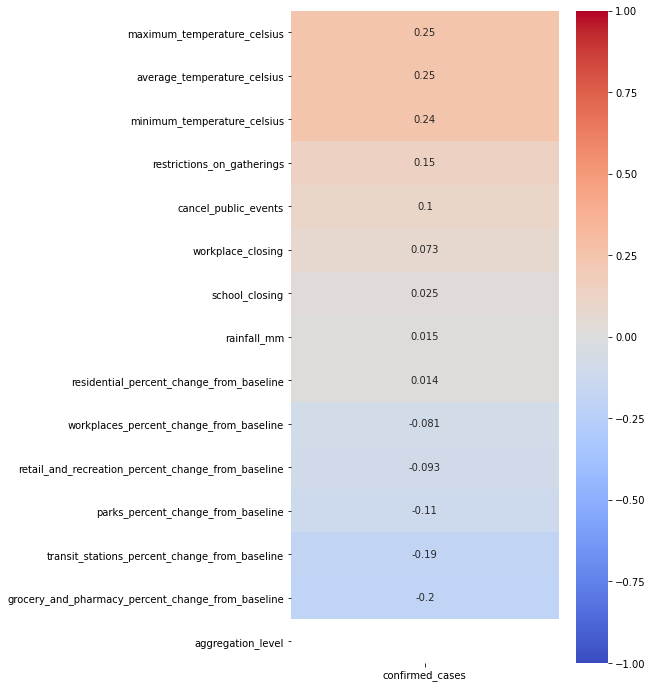

In [6]:
plt.figure(figsize=(6,12))
sns.heatmap(open_data.corr()[['confirmed_cases']].head(15).sort_values(by='confirmed_cases', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1);

In [7]:
# post correlation review
open_data = open_data.drop(columns = ['aggregation_level', 'international_support'])

### Symptoms

In [8]:
symptom_2019=pd.read_csv('symptom_state_2019.csv')
symptom_2020=pd.read_csv('symptom_state_2020.csv')
covid_case=pd.read_csv('covid_case.csv')

In [9]:
covid_case.drop(columns=['Unnamed: 0','state_fips_code'],inplace=True)

In [10]:
covid_case.head()

date state_name  confirmed_cases  deaths
0  2020-03-15       Guam                3       0
1  2020-03-16       Guam                3       0
2  2020-03-17       Guam                3       0
3  2020-03-18       Guam                8       0
4  2020-03-19       Guam               12       0

In [11]:
symptom_2019.drop(columns=['Unnamed: 0','country_region_code','country_region',
                            'sub_region_1_code','sub_region_2_code','sub_region_2'],inplace=True)

symptom_2020.drop(columns=['Unnamed: 0','country_region_code','country_region',
                            'sub_region_1_code','sub_region_2_code','sub_region_2'],inplace=True)

In [12]:
symptom_2019['date']=pd.to_datetime(symptom_2019['date'])
symptom_2020['date']=pd.to_datetime(symptom_2020['date'])
covid_case['date']=pd.to_datetime(covid_case['date'])

In [13]:
from datetime import datetime as dt

In [14]:
symptom_2019['month']=pd.DatetimeIndex(symptom_2019['date']).month
symptom_2019['day']=pd.DatetimeIndex(symptom_2019['date']).day

symptom_2020['month']=pd.DatetimeIndex(symptom_2020['date']).month
symptom_2020['day']=pd.DatetimeIndex(symptom_2020['date']).day

covid_case['month']=pd.DatetimeIndex(covid_case['date']).month
covid_case['day']=pd.DatetimeIndex(covid_case['date']).day

In [15]:
symptom_2019.rename(columns={'sub_region_1':'state'},inplace=True)
symptom_2020.rename(columns={'sub_region_1':'state'},inplace=True)
covid_case.rename(columns={'state_name':'state'},inplace=True)

In [16]:
symptom_2020=pd.merge(covid_case,symptom_2020,left_on=['state','month','day'],right_on=['state','month','day'])

In [17]:
symptom_merge=pd.merge(symptom_2020,symptom_2019,left_on=['state','month','day'],right_on=['state','month','day'])

In [18]:
symptom_merge.isnull().sum().sort_values().tail(300)

symptom_Bells_palsy_x                                  2143
symptom_Encephalitis_x                                 2151
symptom_Chills_y                                       2189
symptom_Congenital_heart_defect_y                      2204
symptom_Cluster_headache_y                             2206
symptom_Hypertriglyceridemia_x                         2222
symptom_Acute_bronchitis_x                             2226
symptom_Cheilitis_y                                    2261
symptom_Unconsciousness_y                              2266
symptom_Avoidant_personality_disorder_x                2266
symptom_Hematochezia_x                                 2267
symptom_Lymphedema_x                                   2271
symptom_Neuralgia_y                                    2276
symptom_Visual_acuity_x                                2278
symptom_Mydriasis_x                                    2285
symptom_Bells_palsy_y                                  2287
symptom_Mydriasis_y                     

In [19]:
symptom_merge.corr()['confirmed_cases'][symptom_merge.corr()['confirmed_cases']>.5]

confirmed_cases    1.000000
deaths             0.770677
Name: confirmed_cases, dtype: float64

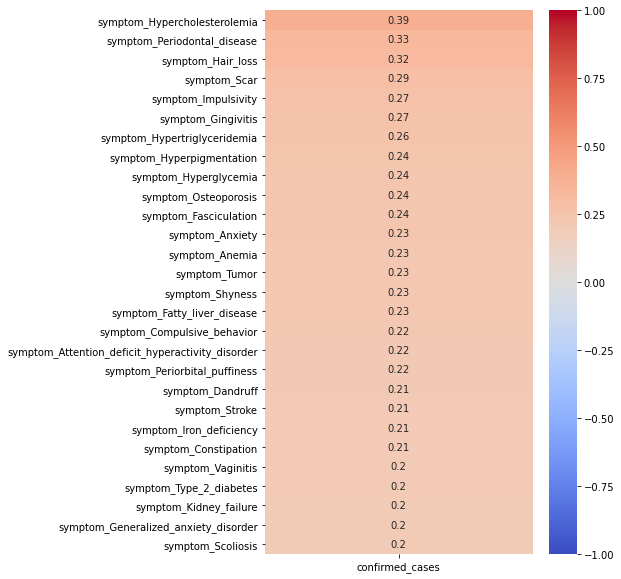

In [20]:
corre=symptom_2020.corr()

plt.figure(figsize=(6,10))
sns.heatmap(corre[['confirmed_cases']][corre['confirmed_cases']>.20][corre['confirmed_cases']<.40].sort_values(by='confirmed_cases', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1);

In [21]:
corre['confirmed_cases'][corre['confirmed_cases']>.2].sort_values(ascending=False)

confirmed_cases                                     1.000000
deaths                                              0.770725
month                                               0.423399
symptom_Hypercholesterolemia                        0.385139
symptom_Periodontal_disease                         0.330643
symptom_Hair_loss                                   0.318705
symptom_Scar                                        0.288878
symptom_Impulsivity                                 0.271773
symptom_Gingivitis                                  0.265088
symptom_Hypertriglyceridemia                        0.263977
symptom_Hyperpigmentation                           0.243533
symptom_Hyperglycemia                               0.240746
symptom_Osteoporosis                                0.236070
symptom_Fasciculation                               0.235807
symptom_Anxiety                                     0.234870
symptom_Anemia                                      0.230936
symptom_Tumor           

In [22]:
corre['deaths'][corre['deaths']>.2][corre['deaths']<1].sort_values(ascending=False)

confirmed_cases                  0.770725
symptom_Hair_loss                0.354096
month                            0.290521
symptom_Hypercholesterolemia     0.284911
symptom_Hyperpigmentation        0.270972
symptom_Scar                     0.253193
symptom_Periodontal_disease      0.232854
symptom_Dandruff                 0.224815
symptom_Periorbital_puffiness    0.219359
Name: deaths, dtype: float64

In [23]:
corre['confirmed_cases'][corre['confirmed_cases']<-.2].sort_values()

symptom_Viral_pneumonia                     -0.407205
symptom_Croup                               -0.297421
symptom_Allergic_conjunctivitis             -0.294562
symptom_Pleurisy                            -0.290744
symptom_Acute_bronchitis                    -0.272894
symptom_Shallow_breathing                   -0.266834
symptom_Laryngitis                          -0.263938
symptom_Wheeze                              -0.256020
symptom_Sputum                              -0.241272
symptom_Upper_respiratory_tract_infection   -0.239622
symptom_Bronchitis                          -0.234260
symptom_Crackles                            -0.229075
symptom_Low_grade_fever                     -0.211305
symptom_Common_cold                         -0.210062
symptom_Burning_Chest_Pain                  -0.210060
symptom_Aphonia                             -0.205687
symptom_Photodermatitis                     -0.204769
symptom_Erythema_chronicum_migrans          -0.204252
symptom_Infection           

In [24]:
columns_2020=symptom_2020.drop(columns=['date_x', 'state', 'confirmed_cases', 'deaths', 'month', 'day',
       'date_y']).columns

In [25]:
columns_2019=symptom_2019.drop(columns=['state', 'date','month','day']).columns

In [26]:
columns_2020=[str(x)+'_x' for x in list(columns_2020)]
columns_2019=[str(x)+'_y' for x in list(columns_2019)]

zipped_columns=list(zip(columns_2020,columns_2019));

In [27]:
symptoms_merge_2=symptom_merge[['date_x','state','confirmed_cases','deaths','month','day']]

In [28]:
for i in zipped_columns:
    symptoms_merge_2=symptoms_merge_2.merge(pd.DataFrame(symptom_merge[i[0]].sub(symptom_merge[i[1]])).rename(columns={0:f'{i[0]}'}),left_index=True,right_index=True)
    

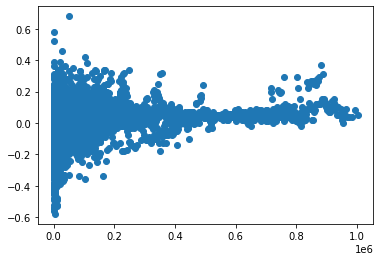

In [29]:
plt.scatter(symptoms_merge_2['confirmed_cases'],symptoms_merge_2['symptom_Tic_x'])

* Difficult to see a direct correlation

In [30]:
corre_difference=symptoms_merge_2.corr()

In [31]:
corre_difference['confirmed_cases'][corre_difference['confirmed_cases']>.15].sort_values(ascending=False)

confirmed_cases                         1.000000
deaths                                  0.770677
month                                   0.423233
symptom_Tic_x                           0.277377
symptom_Dysphoria_x                     0.263543
symptom_Clouding_of_consciousness_x     0.257516
symptom_Depersonalization_x             0.232017
symptom_Biliary_colic_x                 0.225023
symptom_Hyperglycemia_x                 0.215971
symptom_Hypercholesterolemia_x          0.214531
symptom_Hyperemesis_gravidarum_x        0.211626
symptom_Mood_swing_x                    0.201263
symptom_Confusion_x                     0.201186
symptom_Astigmatism_x                   0.200494
symptom_Gastroparesis_x                 0.194742
symptom_Depression_x                    0.192661
symptom_Blurred_vision_x                0.191672
symptom_Hyperkalemia_x                  0.191215
symptom_Impulsivity_x                   0.189756
symptom_Stuttering_x                    0.189404
symptom_Fibromyalgia

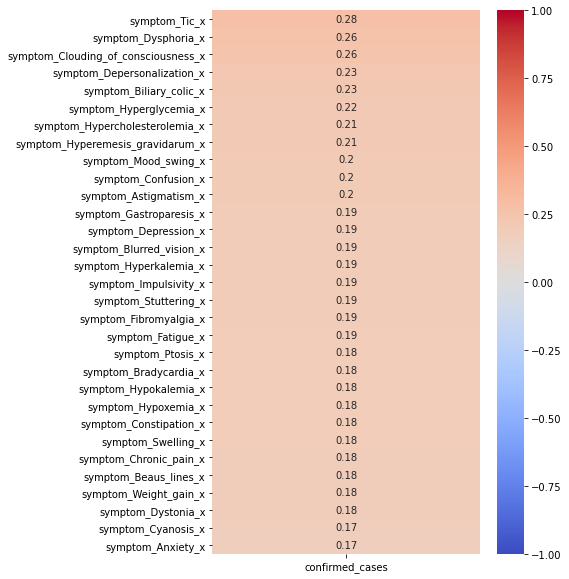

In [32]:
plt.figure(figsize=(6,10))
sns.heatmap(corre_difference[['confirmed_cases']][corre_difference['confirmed_cases']>.17][corre_difference['confirmed_cases']<.4].sort_values(by='confirmed_cases',ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1);

* Many of the top correlated terms refer to behaviorial symptoms instead of more concrete symptoms. Terms like dysphoria, confusion, depression, anxiety. 

In [33]:
corre_difference['deaths'][corre_difference['deaths']<-.2].sort_values(ascending=False)

symptom_Upper_respiratory_tract_infection_x   -0.204740
symptom_Low_grade_fever_x                     -0.208915
symptom_Bronchitis_x                          -0.210441
symptom_Post_nasal_drip_x                     -0.217558
symptom_Phlegm_x                              -0.220064
symptom_Common_cold_x                         -0.221531
symptom_Acute_bronchitis_x                    -0.228338
symptom_Croup_x                               -0.230836
symptom_Sputum_x                              -0.249669
symptom_Viral_pneumonia_x                     -0.324464
Name: deaths, dtype: float64

In [34]:
col=symptoms_merge_2.drop(columns=['date_x', 'state', 'confirmed_cases', 'deaths', 'month', 'day']).columns

In [35]:
diff_year=pd.DataFrame(columns=['symptom','diff'])
for columns in col:
    temp={'symptom':columns,'diff':symptoms_merge_2[columns].sum()}
    diff_year=diff_year.append(temp,ignore_index=True) 

In [36]:
diff_year_top_20_corr=diff_year.sort_values(by='diff',ascending=False).head(20)

In [37]:
diff_year_top_20_corr

symptom      diff
217                        symptom_Infection_x  49424.77
84                       symptom_Common_cold_x  36323.63
141                            symptom_Fever_x  21838.18
2                               symptom_Acne_x   6865.41
417                        symptom_Xeroderma_x   6552.13
25                         symptom_Arthritis_x   4775.56
152  symptom_Gastroesophageal_reflux_disease_x   3748.97
165                        symptom_Hair_loss_x   3687.56
0                  symptom_Abdominal_obesity_x   3627.73
29                            symptom_Asthma_x   3334.81
171                        symptom_Heartburn_x   2436.41
350              symptom_Shortness_of_breath_x   2316.57
167                        symptom_Hay_fever_x   1958.86
74                        symptom_Chest_pain_x   1853.72
211                        symptom_Hypoxemia_x   1758.88
197                     symptom_Hyperthermia_x   1535.31
240                  symptom_Low_grade_fever_x   1446.44
98                          symptom_Dandruff_x   1144.49
194                symptom_Hyperpigmentation_x   1140.16
168                         symptom_Headache_x   1118.12

In [ ]:
for x in diff_year_top_20_corr['symptom']:
    symptom_nafill[x.replace('_x','_sub')]

In [42]:
for x in diff_year_top_20_corr['symptom_2']:
    x=x.replace('symptom_','').replace('_x','')

In [52]:
diff_year_top_20_corr['symptom_2']=diff_year_top_20_corr['symptom_2'].str.replace('_x','').str.replace('symptom_','').str.replace('_',' ')

In [53]:
diff_year_top_20_corr

symptom      diff  \
217                        symptom_Infection_x  49424.77   
84                       symptom_Common_cold_x  36323.63   
141                            symptom_Fever_x  21838.18   
2                               symptom_Acne_x   6865.41   
417                        symptom_Xeroderma_x   6552.13   
25                         symptom_Arthritis_x   4775.56   
152  symptom_Gastroesophageal_reflux_disease_x   3748.97   
165                        symptom_Hair_loss_x   3687.56   
0                  symptom_Abdominal_obesity_x   3627.73   
29                            symptom_Asthma_x   3334.81   
171                        symptom_Heartburn_x   2436.41   
350              symptom_Shortness_of_breath_x   2316.57   
167                        symptom_Hay_fever_x   1958.86   
74                        symptom_Chest_pain_x   1853.72   
211                        symptom_Hypoxemia_x   1758.88   
197                     symptom_Hyperthermia_x   1535.31   
240                  symptom_Low_grade_fever_x   1446.44   
98                          symptom_Dandruff_x   1144.49   
194                symptom_Hyperpigmentation_x   1140.16   
168                         symptom_Headache_x   1118.12   

                           symptom_2  
217                        Infection  
84                       Common cold  
141                            Fever  
2                               Acne  
417                        Xeroderma  
25                         Arthritis  
152  Gastroesophageal reflux disease  
165                        Hair loss  
0                  Abdominal obesity  
29                            Asthma  
171                        Heartburn  
350              Shortness of breath  
167                        Hay fever  
74                        Chest pain  
211                        Hypoxemia  
197                     Hyperthermia  
240                  Low grade fever  
98                          Dandruff  
194                Hyperpigmentation  
168                         Headache

Text(0, 0.5, 'Summed Relative Frequency Compared to 2019')

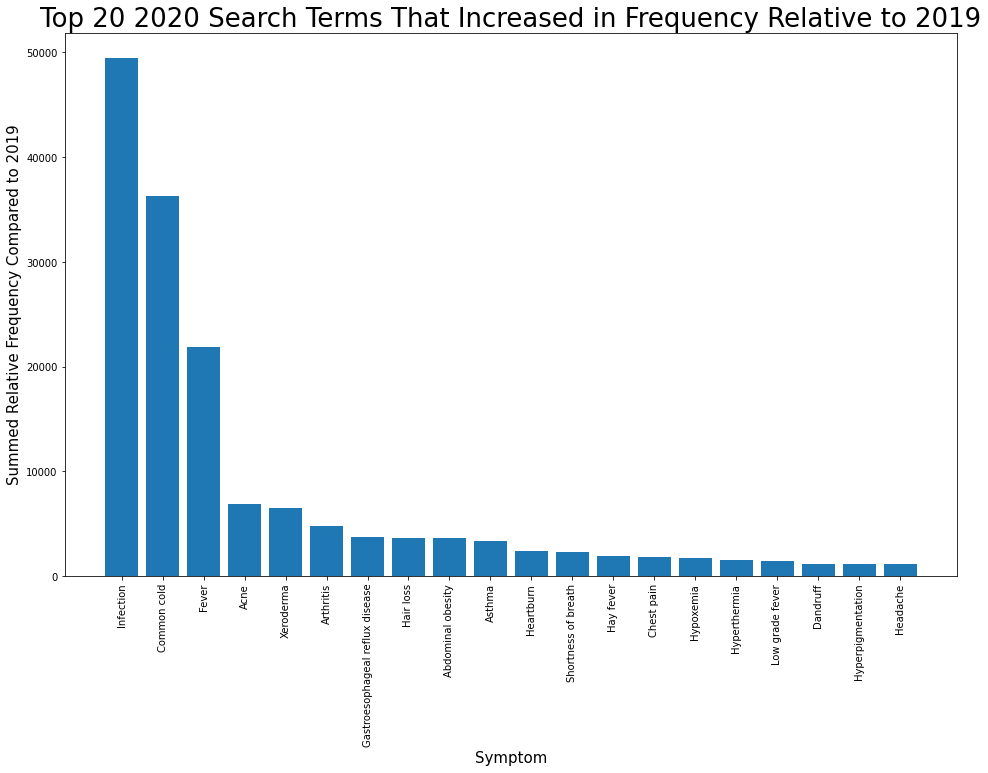

In [59]:

plt.figure(figsize=(16,10))
plt.bar(diff_year_top_20_corr['symptom_2'],diff_year_top_20_corr['diff'])
plt.xticks(rotation='vertical')
plt.title('Top 20 2020 Search Terms That Increased in Frequency Relative to 2019', fontsize=26)
plt.xlabel('Symptom',fontsize=15)
plt.ylabel('Summed Relative Frequency Compared to 2019',fontsize=15)

Note:
* Searches for infection, common cold and fever occurred much more this year 2020 then last year

In [41]:
list(diff_year.sort_values(by='diff',ascending=False).head(20)['symptom'])

['symptom_Infection_x',
 'symptom_Common_cold_x',
 'symptom_Fever_x',
 'symptom_Acne_x',
 'symptom_Xeroderma_x',
 'symptom_Arthritis_x',
 'symptom_Gastroesophageal_reflux_disease_x',
 'symptom_Hair_loss_x',
 'symptom_Abdominal_obesity_x',
 'symptom_Asthma_x',
 'symptom_Heartburn_x',
 'symptom_Shortness_of_breath_x',
 'symptom_Hay_fever_x',
 'symptom_Chest_pain_x',
 'symptom_Hypoxemia_x',
 'symptom_Hyperthermia_x',
 'symptom_Low_grade_fever_x',
 'symptom_Dandruff_x',
 'symptom_Hyperpigmentation_x',
 'symptom_Headache_x']

In [42]:
pd.DataFrame(diff_year.sort_values(by='diff',ascending=False).head(20)['symptom'])

symptom
217                        symptom_Infection_x
84                       symptom_Common_cold_x
141                            symptom_Fever_x
2                               symptom_Acne_x
417                        symptom_Xeroderma_x
25                         symptom_Arthritis_x
152  symptom_Gastroesophageal_reflux_disease_x
165                        symptom_Hair_loss_x
0                  symptom_Abdominal_obesity_x
29                            symptom_Asthma_x
171                        symptom_Heartburn_x
350              symptom_Shortness_of_breath_x
167                        symptom_Hay_fever_x
74                        symptom_Chest_pain_x
211                        symptom_Hypoxemia_x
197                     symptom_Hyperthermia_x
240                  symptom_Low_grade_fever_x
98                          symptom_Dandruff_x
194                symptom_Hyperpigmentation_x
168                         symptom_Headache_x

In [43]:
diff_year['symptom']=diff_year['symptom'].str.replace('symptom_','')

diff_year['symptom']=diff_year['symptom'].str.replace('_x','')

diff_year['symptom']=diff_year['symptom'].str.replace('_',' ')

### Mask

#### USA

In [54]:
! pip install plotly

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=603a3599548a42ae88a434d90c2479a45358e206046fde6f75cd8f20b4ef463e
  Stored in directory: c:\users\smoha.laptop-d47u0qa5\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [78]:
import plotly.graph_objects as go
import seaborn as sns
sns.set()
import plotly.io as pio
pio.renderers.default = 'notebook'

In [79]:
df = pd.read_csv('mask_pop.csv', index_col=0)
df.head()

state_name   total_pop  confirmed_cases  deaths  never  rarely  sometimes  \
0     Alabama   4887871.0            26232     409   0.08    0.08       0.15   
1      Alaska    737438.0            10632      55   0.05    0.07       0.09   
2     Arizona   7171646.0           169309    3734   0.05    0.05       0.09   
3    Arkansas   3013825.0            13475     230   0.09    0.09       0.14   
4  California  39557045.0           325951    7200   0.03    0.03       0.06   

   frequently  always  deaths_per_case  infection_rate  death_per_population  
0        0.22    0.48           0.0156          0.0054              0.000084  
1        0.32    0.47           0.0052          0.0144              0.000075  
2        0.15    0.66           0.0221          0.0236              0.000521  
3        0.22    0.46           0.0171          0.0045              0.000076  
4        0.16    0.72           0.0221          0.0082              0.000182

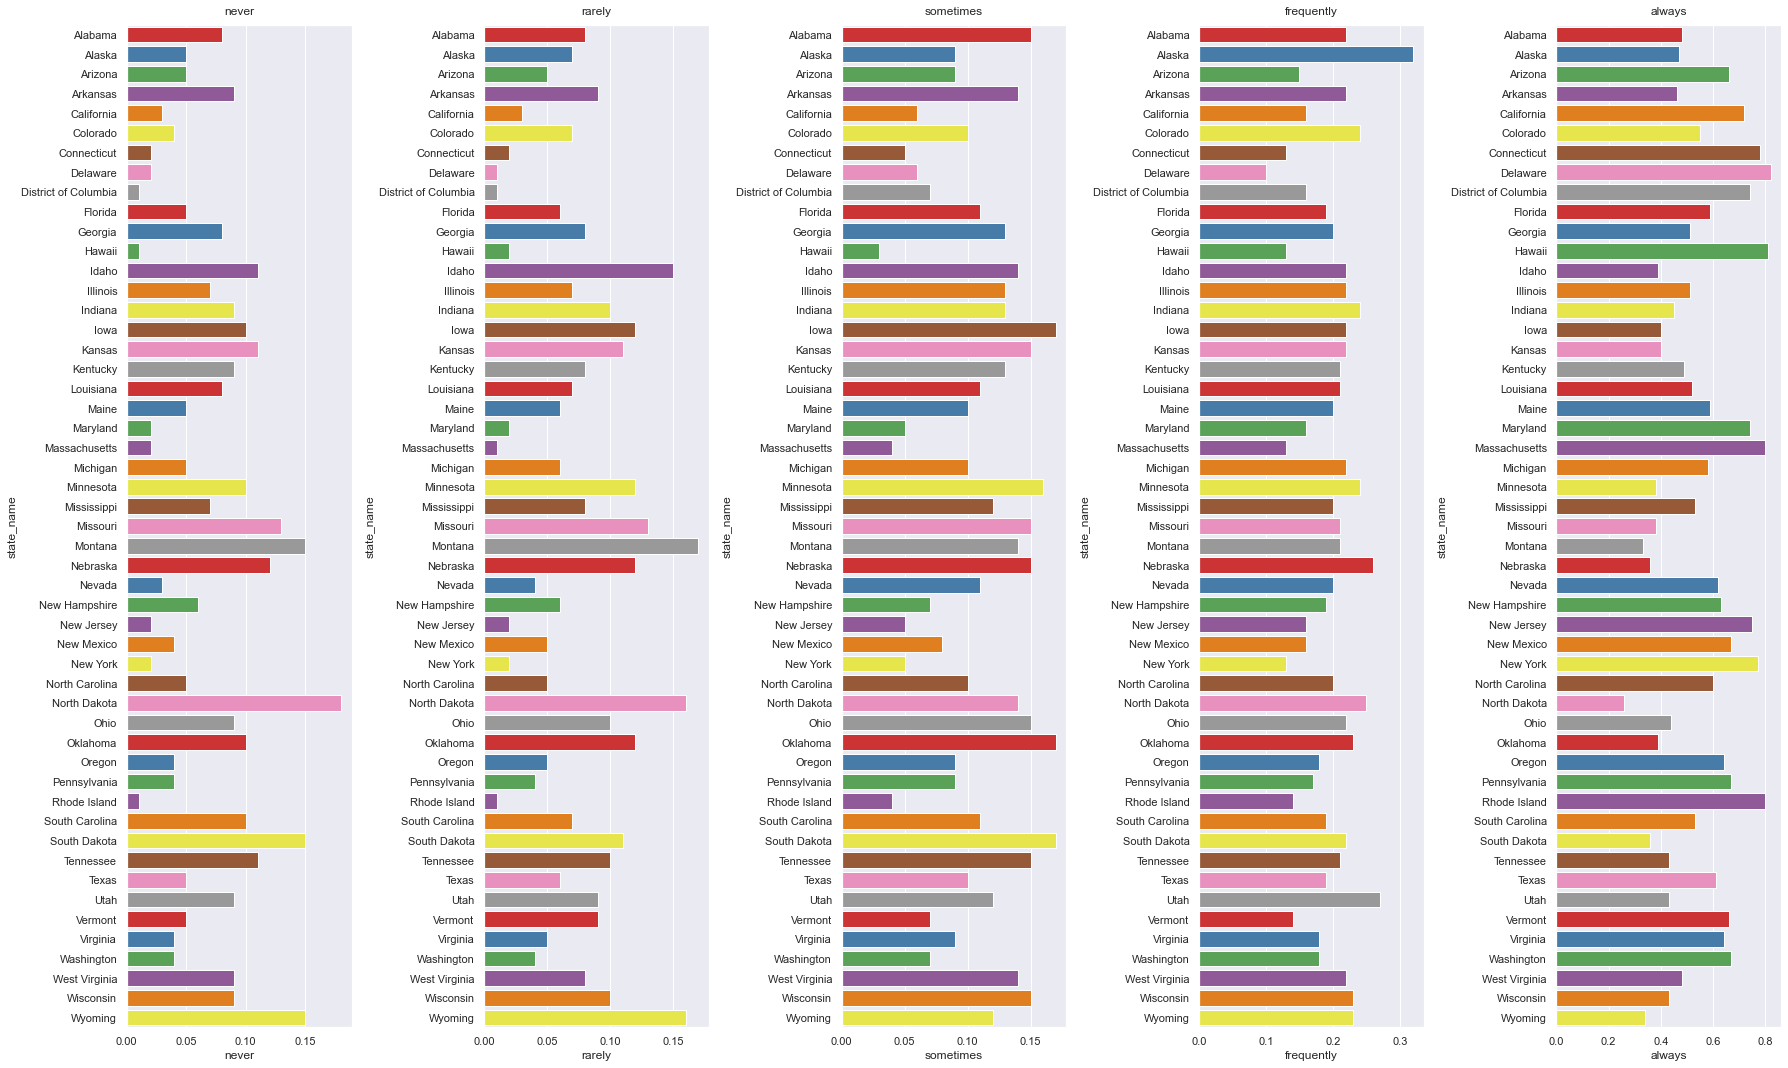

In [80]:
fig, ax = plt.subplots(figsize=(25, 15))

plt.subplot(1, 5, 1)
sns.barplot(x='never', y='state_name', data=df, palette='Set1')
plt.title('never', fontsize=12, pad=10)

plt.subplot(1, 5, 2)
sns.barplot(x='rarely', y='state_name', data=df, palette='Set1')
plt.title('rarely', fontsize=12, pad=10)

plt.subplot(1, 5, 3)
sns.barplot(x='sometimes', y='state_name', data=df, palette='Set1')
plt.title('sometimes', fontsize=12, pad=10)

plt.subplot(1, 5, 4)
sns.barplot(x='frequently', y='state_name', data=df, palette='Set1')
plt.title('frequently', fontsize=12, pad=10)

plt.subplot(1, 5, 5)
sns.barplot(x='always', y='state_name', data=df, palette='Set1')
plt.title('always', fontsize=12, pad=10)
plt.tight_layout();

In [81]:
df[df['never']==df['never'].max()][['state_name','never']]

state_name  never
34  North Dakota   0.18

In [82]:
df[df['never']==df['never'].min()][['state_name','never']]


state_name  never
8   District of Columbia   0.01
11                Hawaii   0.01
39          Rhode Island   0.01

In [83]:
df[df['rarely'] == df['rarely'].max()][['state_name','rarely']]


state_name  rarely
26    Montana    0.17

In [84]:
df[df['rarely'] == df['rarely'].min()][['state_name','rarely']]


state_name  rarely
7               Delaware    0.01
8   District of Columbia    0.01
21         Massachusetts    0.01
39          Rhode Island    0.01

In [85]:
df[df['sometimes'] == df['sometimes'].max()][['state_name','sometimes']]


state_name  sometimes
15          Iowa       0.17
36      Oklahoma       0.17
41  South Dakota       0.17

In [86]:
df[df['sometimes'] == df['sometimes'].min()][['state_name','sometimes']]


state_name  sometimes
11     Hawaii       0.03

In [87]:
df[df['frequently'] == df['frequently'].max()][['state_name','frequently']]


state_name  frequently
1     Alaska        0.32

In [88]:
df[df['sometimes'] == df['sometimes'].min()][['state_name','frequently']]


state_name  frequently
11     Hawaii        0.13

In [89]:
df[df['always'] == df['always'].max()][['state_name','always']]


state_name  always
7   Delaware    0.82

In [90]:
df[df['always'] == df['always'].min()][['state_name','always']]


state_name  always
34  North Dakota    0.26

In [91]:

code = ['AL','AK','AZ','AR','CA','CO','CT','DC','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA',
        'ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR',
        'PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

df['code'] = code
df.head()

state_name   total_pop  confirmed_cases  deaths  never  rarely  sometimes  \
0     Alabama   4887871.0            26232     409   0.08    0.08       0.15   
1      Alaska    737438.0            10632      55   0.05    0.07       0.09   
2     Arizona   7171646.0           169309    3734   0.05    0.05       0.09   
3    Arkansas   3013825.0            13475     230   0.09    0.09       0.14   
4  California  39557045.0           325951    7200   0.03    0.03       0.06   

   frequently  always  deaths_per_case  infection_rate  death_per_population  \
0        0.22    0.48           0.0156          0.0054              0.000084   
1        0.32    0.47           0.0052          0.0144              0.000075   
2        0.15    0.66           0.0221          0.0236              0.000521   
3        0.22    0.46           0.0171          0.0045              0.000076   
4        0.16    0.72           0.0221          0.0082              0.000182   

  code  
0   AL  
1   AK  
2   AZ  
3   AR  
4   CA

In [92]:
# text content should be str format for display

for col in df.columns:
    df[col] = df[col].astype(str)

df['text'] = df['state_name'] + '<br>' + \
    'Population: ' + df['total_pop'] + '<br>' + \
    'Confirmed Cases: ' + df['confirmed_cases'] + '<br>' + \
    'Deaths: ' + df['deaths'] + '<br>' + \
    'Mask_never: ' + df['never'] + '<br>' + \
    'Mask_rarely: ' + df['rarely'] + '<br>' + \
    'Mask_sometimes: ' + df['sometimes'] + '<br>' + \
    'Mask_frequently: ' + df['frequently'] + '<br>' + \
    'Mask_always: ' + df['always'] + '<br>' + \
    'Deaths Per Case: ' + df['deaths_per_case'] + '<br>' + \
    'Infection Rate: ' + df['infection_rate'] + '<br>' + \
    'Deaths Per Population: ' + df['death_per_population']

In [93]:
fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = df['confirmed_cases'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    text=df['text'],
    marker_line_color='white',
    colorscale = 'portland',
    colorbar_title = 'Color Scale (confirmed_cases)'
))

fig.update_layout(
    title_text = '2020 US COVID-19 Status by State',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(173,216,230)'),
)

fig.show()

#### New York

In [94]:
import seaborn as sns
sns.set()

%matplotlib inline

In [95]:
df = pd.read_csv('mask_use_by_county.csv', index_col=0)
df.head()

county_fips_code  never  rarely  sometimes  frequently  always
0             15007    0.0   0.021      0.046       0.108   0.825
1             36011    0.0   0.033      0.072       0.162   0.732
2             48209    0.0   0.007      0.022       0.115   0.855
3             51740    0.0   0.019      0.122       0.225   0.634
4             17019    0.0   0.067      0.080       0.192   0.661

In [96]:
df.isnull().sum()


county_fips_code    0
never               0
rarely              0
sometimes           0
frequently          0
always              0
dtype: int64

In [97]:
df.sort_values(by=['county_fips_code'], inplace=True)


In [98]:
df.drop(df[df['county_fips_code'] < 36001].index,inplace=True)
df.drop(df[df['county_fips_code'] > 36123].index,inplace=True)
df = df.reset_index(drop=True)


In [99]:
df['county_name'] = ['Albany','Allegany','Bronx','Broome','Cattaraugus','Cayuga','Chautauqua','Chemung',
                     'Chenango','Clinton','Columbia','Cortland','Delaware','Dutchess','Erie','Essex',
                     'Franklin','Fulton','Genesee','Greene','Hamilton','Herkimer','Jefferson','Kings',
                     'Lewis','Livingston','Madison','Monroe','Montgomery','Nassau','New York','Niagara',
                     'Oneida','Onondaga','Ontario','Orange','Orleans','Oswego','Otsego','Putnam','Queens',
                     'Rensselaer','Richmond','Rockland','Saratoga','Schenectady','Schoharie','Schuyler',
                     'Seneca','St.Lawrence','Steuben','Suffolk','Sullivan','Tioga','Tompkins','Ulster',
                     'Warren','Washington','Wayne','Westchester','Wyoming','Yates']

In [100]:
col_name = 'county_name'
second_col = df.pop(col_name)
df.insert(1, col_name, second_col)

In [101]:
df.head()

county_fips_code  county_name  never  rarely  sometimes  frequently  always
0             36001       Albany  0.006   0.012      0.052       0.142   0.788
1             36003     Allegany  0.062   0.015      0.028       0.124   0.771
2             36005        Bronx  0.043   0.013      0.066       0.136   0.742
3             36007       Broome  0.044   0.028      0.051       0.066   0.812
4             36009  Cattaraugus  0.015   0.013      0.024       0.156   0.793

In [102]:
df.to_csv('mask_clean.csv', index=False)

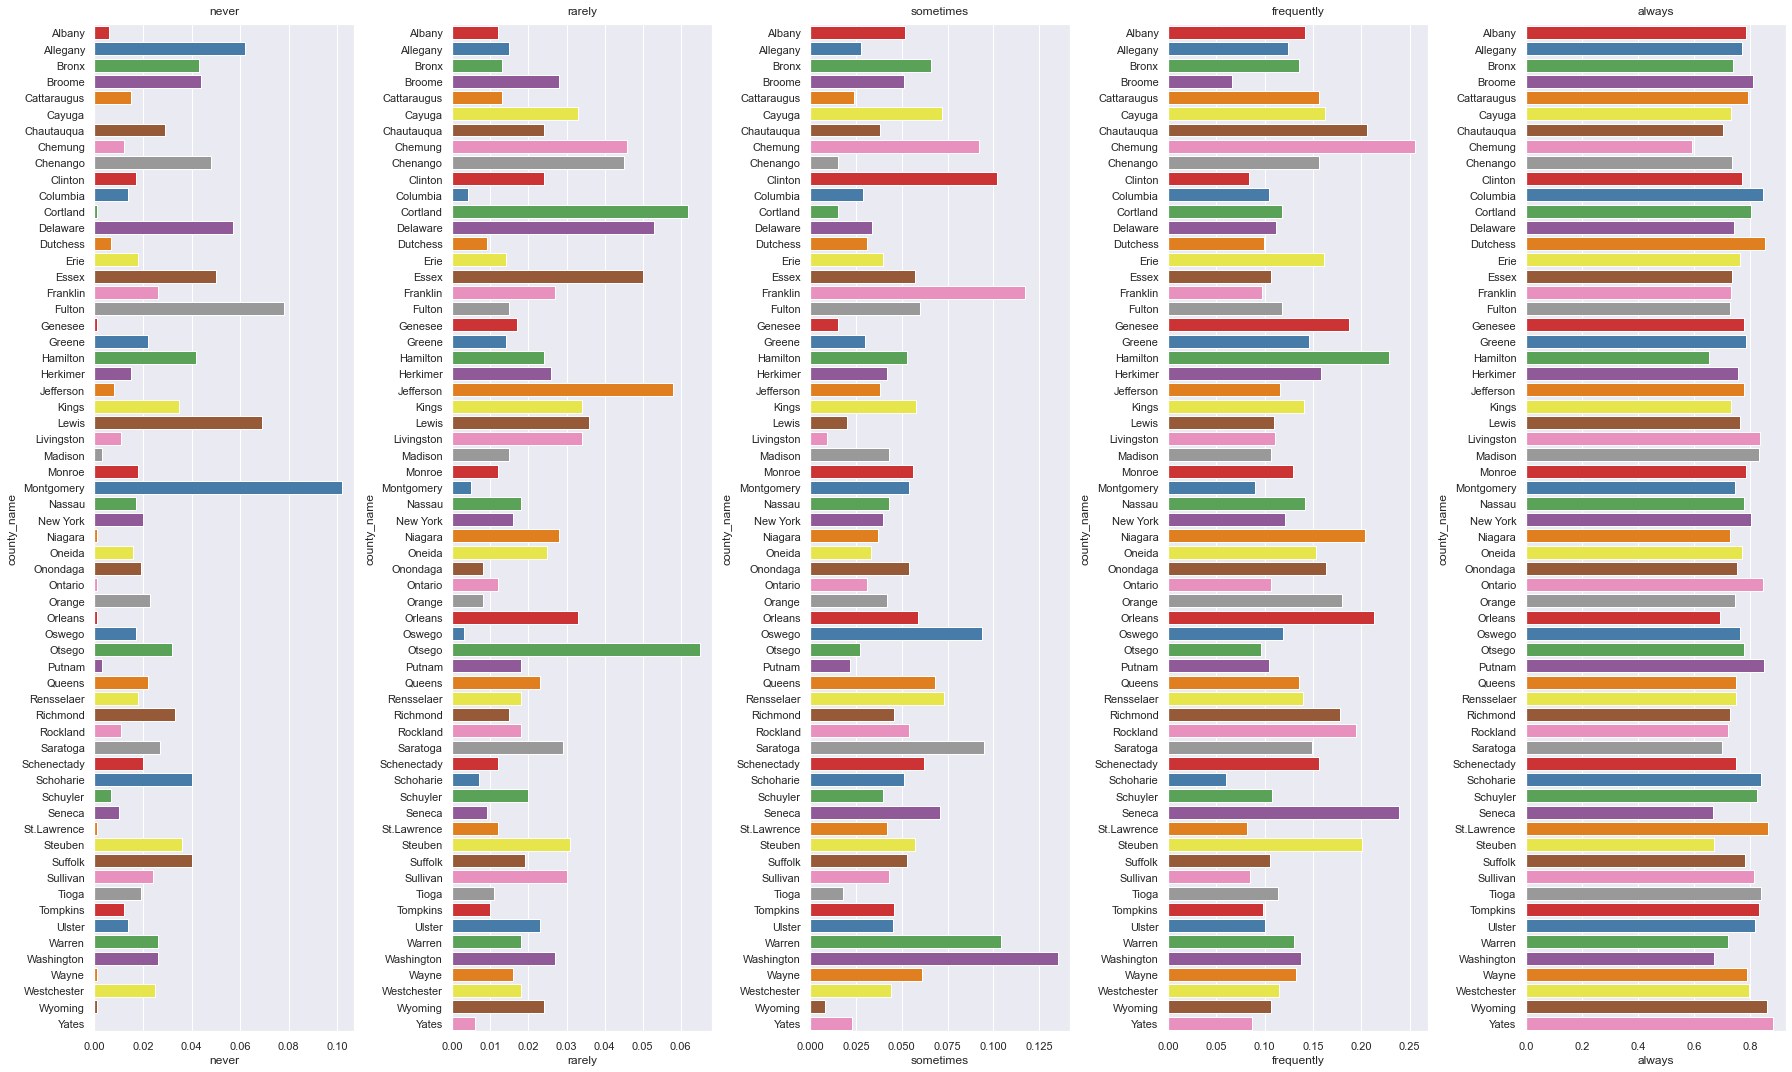

In [103]:

fig, ax = plt.subplots(figsize=(25, 15))

plt.subplot(1, 5, 1)
sns.barplot(x='never', y='county_name', data=df, palette='Set1')
plt.title('never', fontsize=12, pad=10)

plt.subplot(1, 5, 2)
sns.barplot(x='rarely', y='county_name', data=df, palette='Set1')
plt.title('rarely', fontsize=12, pad=10)

plt.subplot(1, 5, 3)
sns.barplot(x='sometimes', y='county_name', data=df, palette='Set1')
plt.title('sometimes', fontsize=12, pad=10)

plt.subplot(1, 5, 4)
sns.barplot(x='frequently', y='county_name', data=df, palette='Set1')
plt.title('frequently', fontsize=12, pad=10)

plt.subplot(1, 5, 5)
sns.barplot(x='always', y='county_name', data=df, palette='Set1')
plt.title('always', fontsize=12, pad=10)
plt.tight_layout();

In [105]:
df[df['never']==df['never'].max()][['county_name','never']]

county_name  never
28  Montgomery  0.102

In [106]:
df[df['never']==df['never'].min()][['county_name','never']]

county_name  never
5       Cayuga    0.0
61       Yates    0.0

In [107]:
df[df['rarely'] == df['rarely'].max()][['county_name','rarely']]

county_name  rarely
38      Otsego   0.065

In [108]:
df[df['rarely'] == df['rarely'].min()][['county_name','rarely']]

county_name  rarely
37      Oswego   0.003

In [109]:

df[df['sometimes'] == df['sometimes'].max()][['county_name','sometimes']]

county_name  sometimes
57  Washington      0.135

In [110]:

df[df['sometimes'] == df['sometimes'].min()][['county_name','sometimes']]

county_name  sometimes
60     Wyoming      0.008

In [111]:
df[df['frequently'] == df['frequently'].max()][['county_name','frequently']]

county_name  frequently
7     Chemung       0.256

In [112]:
df[df['sometimes'] == df['sometimes'].min()][['county_name','frequently']]

county_name  frequently
60     Wyoming       0.107

In [113]:
df[df['always'] == df['always'].max()][['county_name','always']]

county_name  always
61       Yates   0.884

In [114]:
df[df['always'] == df['always'].min()][['county_name','always']]

county_name  always
7     Chemung   0.594

**FOUND:**

    - The most never wareing mask people are living in Montgomery in New York State
    - In Chemung, people prefer to frequntly ware mask but not always
    - In Wyoming, least people ware mask sometimes and frequently

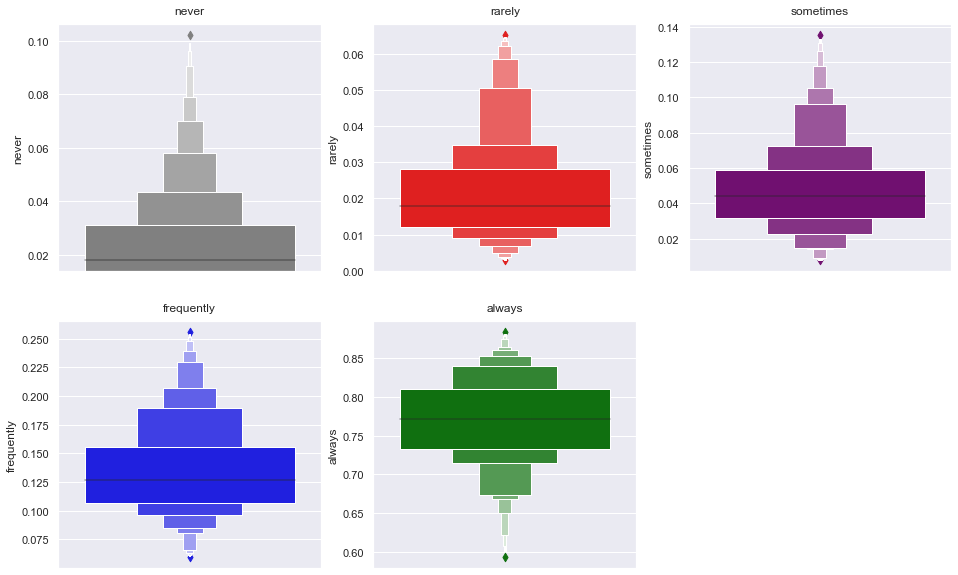

In [115]:

fig, ax = plt.subplots(figsize=(16, 10))

plt.subplot(2, 3, 1)
sns.boxenplot(y='never', data=df, color='grey')
plt.title('never', fontsize=12, pad=10)

plt.subplot(2, 3, 2)
sns.boxenplot(y='rarely', data=df, color='red')
plt.title('rarely', fontsize=12, pad=10)

plt.subplot(2, 3, 3)
sns.boxenplot(y='sometimes', data=df, color='purple')
plt.title('sometimes', fontsize=12, pad=10)

plt.subplot(2, 3, 4)
sns.boxenplot(y='frequently', data=df, color='blue')
plt.title('frequently', fontsize=12, pad=10)

plt.subplot(2, 3, 5)
sns.boxenplot(y='always', data=df, color='green')
plt.title('always', fontsize=12, pad=10);

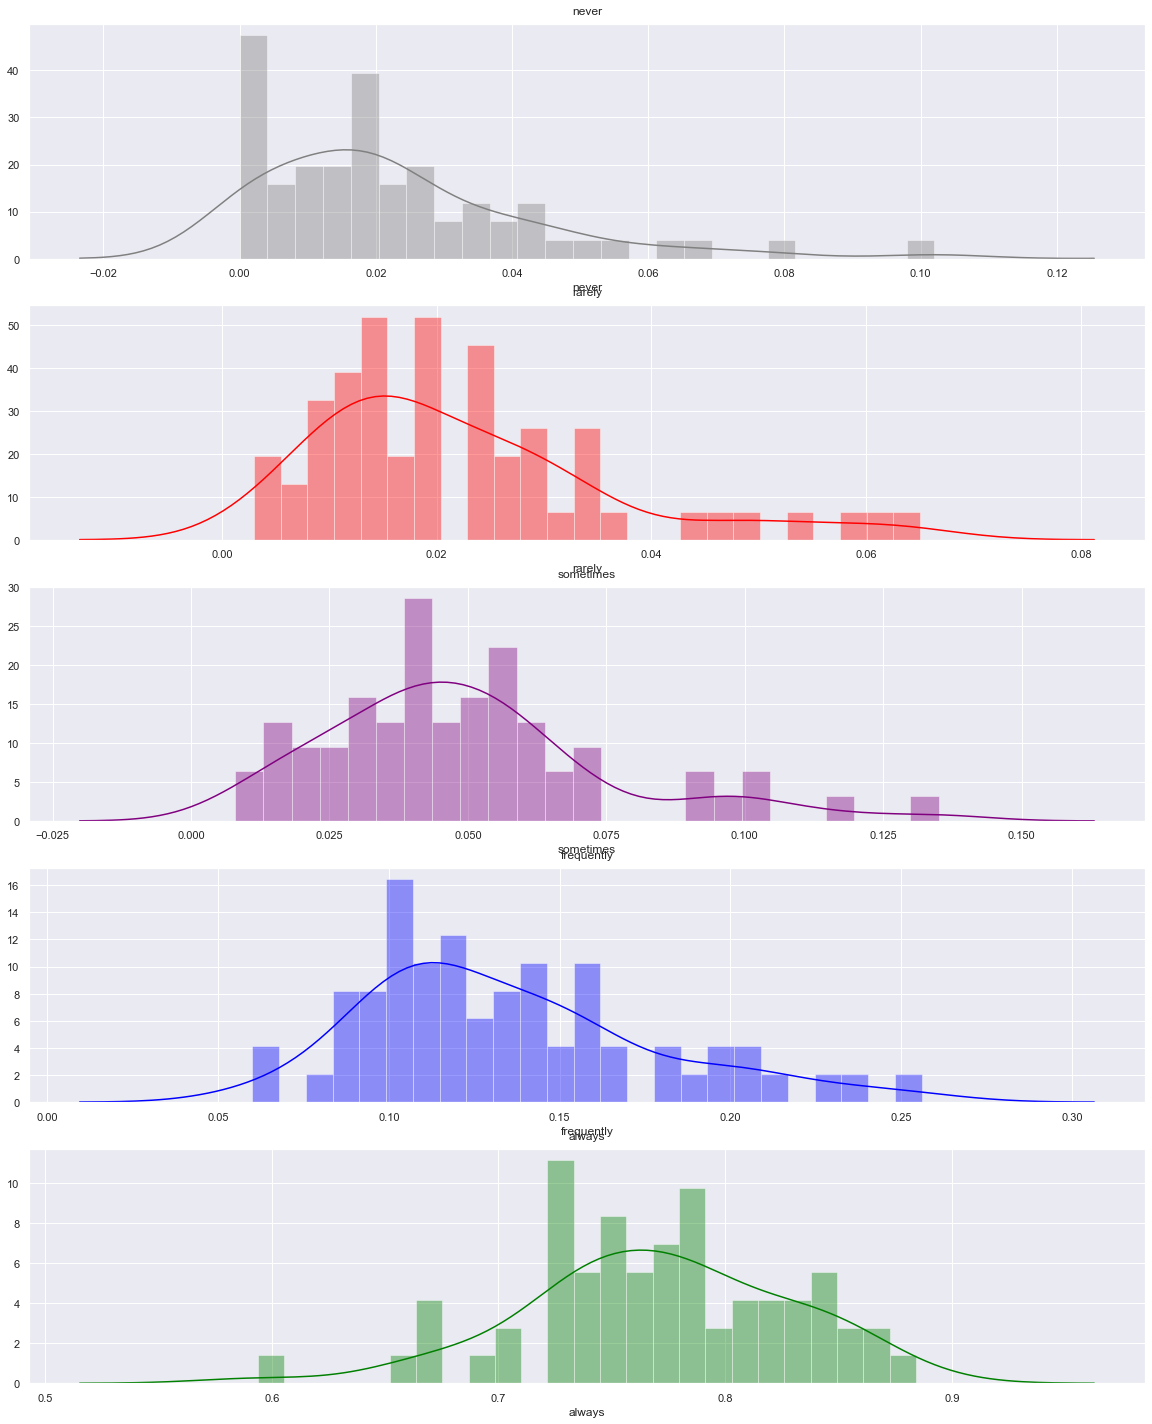

In [118]:
fig, ax = plt.subplots(figsize=(20, 25))

plt.subplot(5, 1, 1)
sns.distplot(a=df['never'], bins=25, color='grey')
plt.title('never', fontsize=12, pad=10)

plt.subplot(5, 1, 2)
sns.distplot(a=df['rarely'], bins=25, color='red')
plt.title('rarely', fontsize=12, pad=10)

plt.subplot(5, 1, 3)
sns.distplot(a=df['sometimes'], bins=25, color='purple')
plt.title('sometimes', fontsize=12, pad=10)

plt.subplot(5, 1, 4)
sns.distplot(a=df['frequently'], bins=25, color='blue')
plt.title('frequently', fontsize=12, pad=10)

plt.subplot(5, 1, 5)
sns.distplot(a=df['always'], bins=25, color='green')
plt.title('always', fontsize=12, pad=10)
plt.tight_layout;

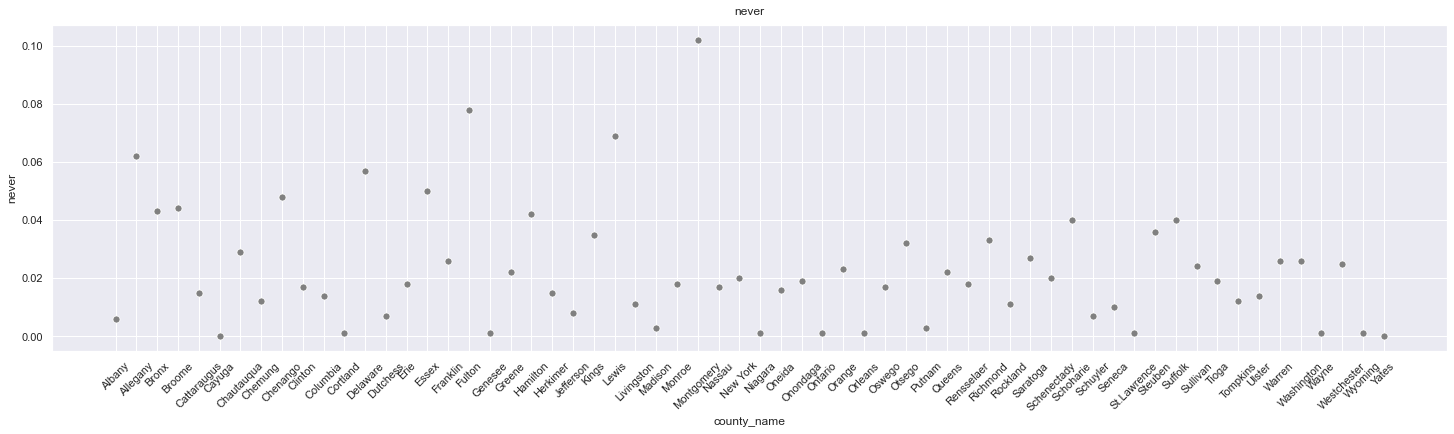

In [119]:
plt.figure(figsize=(25, 6))
sns.scatterplot(x=df['county_name'], y=df['never'], data=df, color='grey', s=50)
plt.xticks(rotation=45)
plt.title('never', fontsize=12, pad=10);

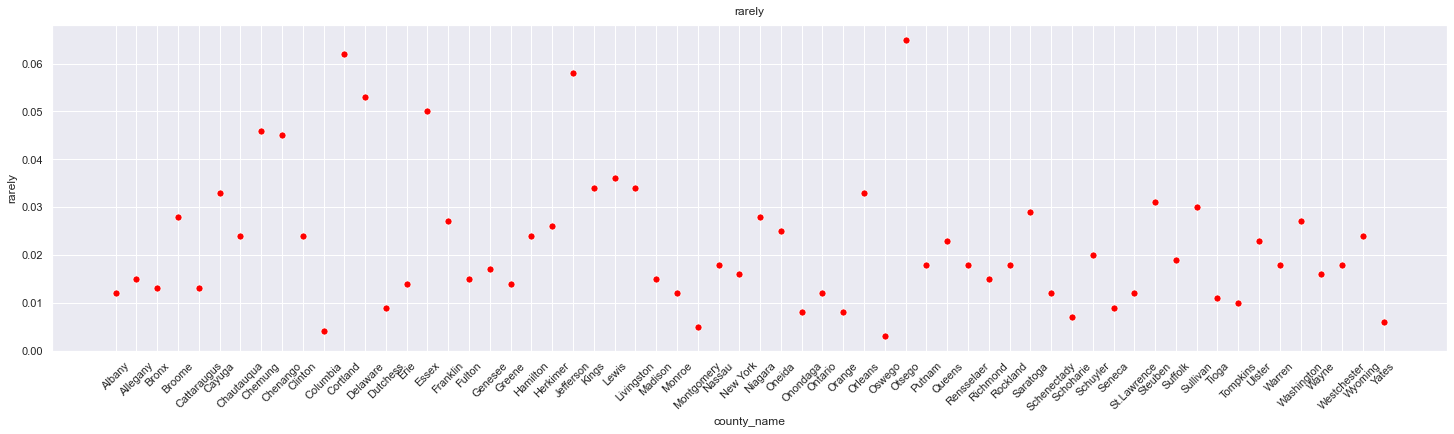

In [120]:
plt.figure(figsize=(25, 6))
sns.scatterplot(x=df['county_name'], y=df['rarely'], data=df, color='red', s=50)
plt.xticks(rotation=45)
plt.title('rarely', fontsize=12, pad=10);

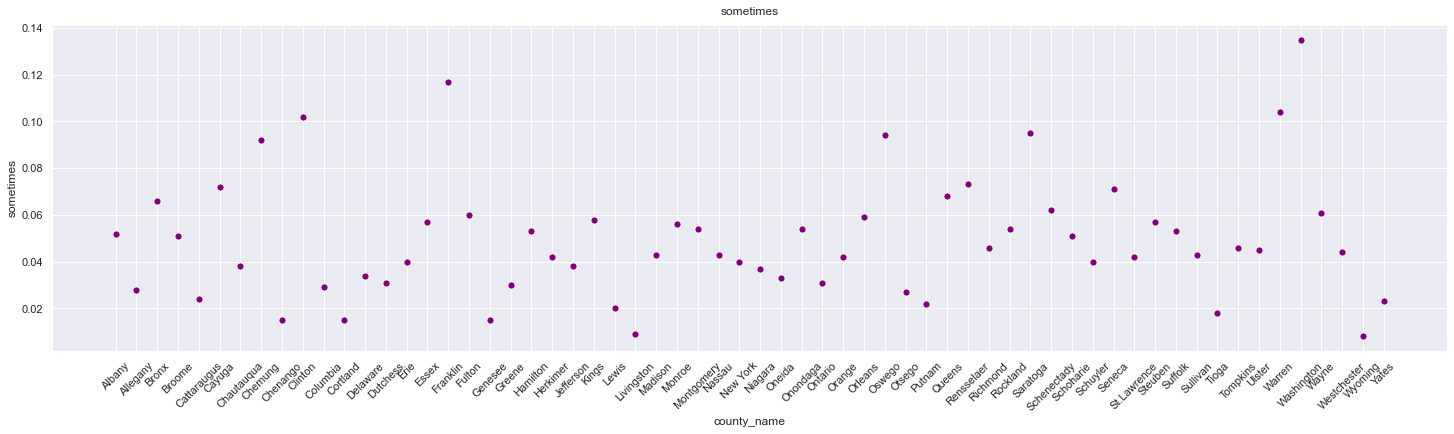

In [121]:

plt.figure(figsize=(25, 6))
sns.scatterplot(x=df['county_name'], y=df['sometimes'], data=df, color='purple', s=50)
plt.xticks(rotation=45)
plt.title('sometimes', fontsize=12, pad=10);

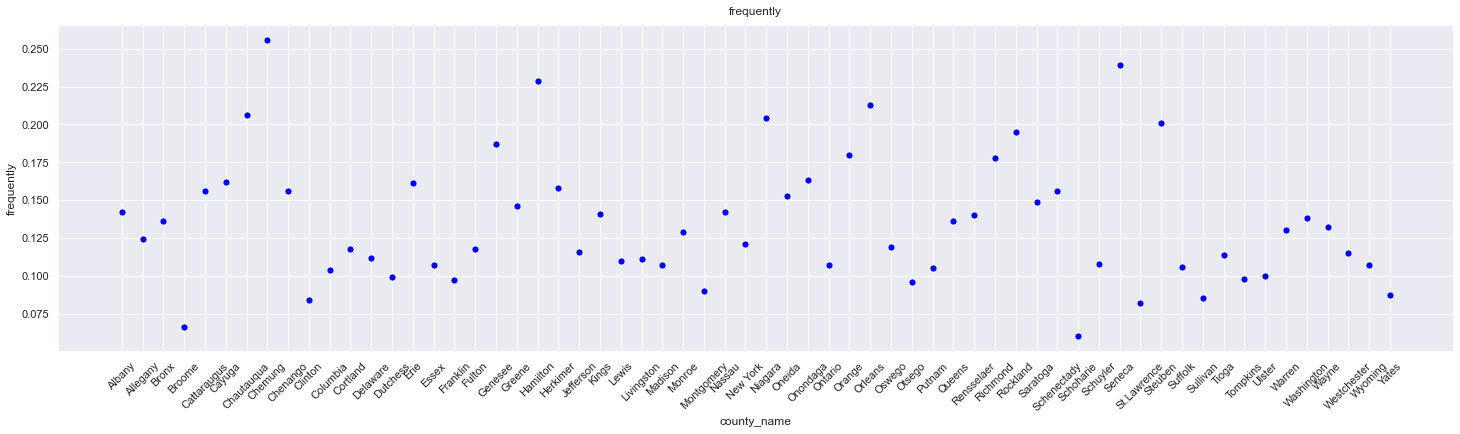

In [122]:

plt.figure(figsize=(25, 6))
sns.scatterplot(x=df['county_name'], y=df['frequently'], data=df, color='blue', s=50)
plt.xticks(rotation=45)
plt.title('frequently', fontsize=12, pad=10);

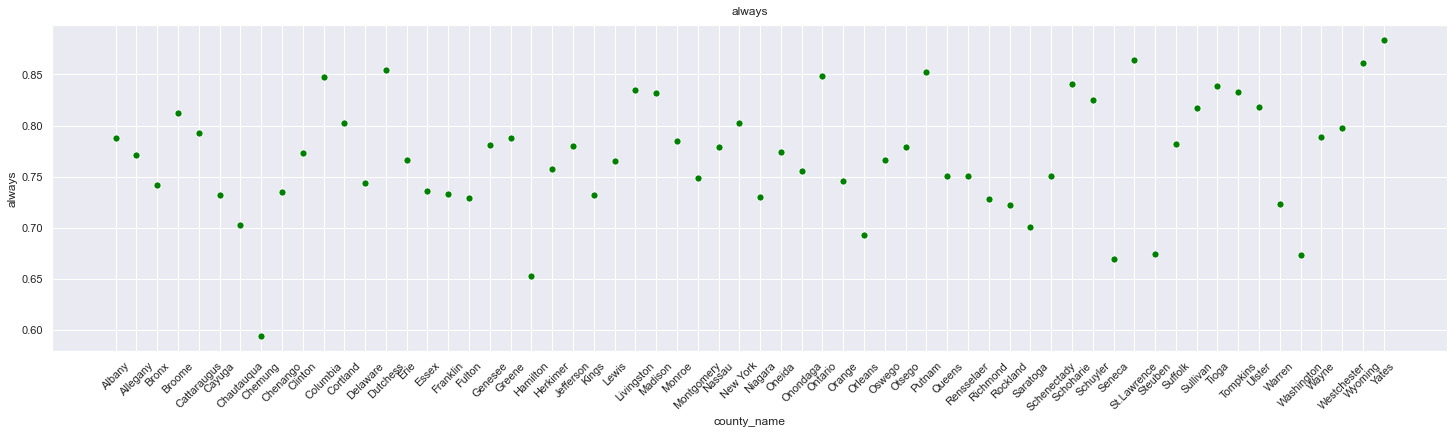

In [123]:

plt.figure(figsize=(25, 6))
sns.scatterplot(x=df['county_name'], y=df['always'], data=df, color='green', s=50)
plt.xticks(rotation=45)
plt.title('always', fontsize=12, pad=10);

In [134]:
import plotly.express as px
import json

import plotly.io as pio
pio.renderers.default = 'notebook'

In [135]:
new_york_state = json.load(open('counties_ny.geojson', 'r'))


In [136]:
# get the counties code

state_id_map = {}
for feature in new_york_state['features']:
    feature['id'] = feature['properties']['fips']
    state_id_map[feature['properties']['county']] = feature['id']


In [137]:
new_york_state['features'][0]['properties']

{'cartodb_id': 27,
 'state_fips': '36',
 'state_name': 'New York',
 'county': 'Putnam',
 'housing_un': None,
 'fips': '36079',
 'county_fip': 79,
 'updated_at': '2012-06-15T00:00:00Z',
 'created_at': '2012-06-15T00:00:00Z'}

In [138]:
df_1 = pd.read_csv('counties_ny.csv')
df_2 = df_1[['county']]

In [139]:

df = pd.read_csv('mask_clean.csv')
df_drop = df.drop(['county_fips_code','county_name'], axis=1)
df_new =pd.concat([df_2, df_drop], axis=1)
df_new.head()

county  never  rarely  sometimes  frequently  always
0       Putnam  0.006   0.012      0.052       0.142   0.788
1     Franklin  0.062   0.015      0.028       0.124   0.771
2      Orleans  0.043   0.013      0.066       0.136   0.742
3  Westchester  0.044   0.028      0.051       0.066   0.812
4       Albany  0.015   0.013      0.024       0.156   0.793

In [140]:
# follow 'get the counties code'
df_new['fips'] = df_new['county'].apply(lambda x : state_id_map[x])

In [141]:
df_new['color_scale_always'] = df_new['always']

In [142]:
fig = px.choropleth_mapbox(df_new, locations='fips', 
                     geojson=new_york_state, 
                     color='color_scale_always',  
                     hover_name='county',
                     title='NY Mask Waring Distribution',
                     hover_data=['never','rarely','sometimes','frequently','always'],
                     color_continuous_scale=px.colors.diverging.curl,
                     mapbox_style='carto-positron', 
                     center={'lat':43, 'lon':-73}, 
                     zoom=5, opacity=0.8)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Modeling

### Open Data (Merged Open Data w/ Policy and Mobility Datasets)

In [150]:
X = open_data.drop(columns = ['confirmed_cases'])
y = open_data['confirmed_cases']

In [151]:
#imports for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression

### Linear Regression

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [153]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

LinearRegression()

In [154]:
lrm.score(X_train, y_train), lrm.score(X_test, y_test)

(0.6818700234502753, 0.6545154134621503)

### Standardizing

In [155]:
sc = StandardScaler()
X_train_s = sc.fit_transform(X_train)
X_test_s = sc.transform(X_test)
mls = LinearRegression()
mls.fit(X_train_s, y_train)

LinearRegression()

In [156]:
print('Standardized Training score:', mls.score(X_train_s, y_train))
print('Standardized Test score:', mls.score(X_test_s, y_test))

Standardized Training score: 0.681870023450277
Standardized Test score: 0.6545154134624912


### Lasso Model

In [157]:
from sklearn.linear_model import Lasso, LassoCV

In [158]:
l_alpha = np.logspace(-3, 0, 100)
lasso_cv = LassoCV(alphas=l_alpha, cv=5, max_iter=50000)
lasso_cv.fit(X_train_s, y_train);

In [159]:
print(lasso_cv.score(X_train_s, y_train))
print(lasso_cv.score(X_test_s, y_test))

0.6817315704873173
0.6545314320934531


### Ridge Model

In [161]:
from sklearn.linear_model import RidgeCV, Ridge

In [162]:
r_alphas = np.logspace(0, 5, 100)
r_alphas
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_cv.fit(X_train_s, y_train);

In [163]:
# optimal alpha from range
ridge_cv.alpha_

1.0

In [164]:
# Instantiate.
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_s, y_train)   
print('Training score:', ridge_model.score(X_train_s, y_train))
print('Test score:', ridge_model.score(X_test_s, y_test))

Training score: 0.6811879713310971
Test score: 0.6541861530725505


### ElasticNet

In [165]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [166]:
enet_alphas = np.linspace(0.5, 1.0, 100)
# l1 ratio
enet_ratio = 0.5
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)
enet_model = enet_model.fit(X_train_s, y_train)
print(enet_model.score(X_train_s, y_train))
print(enet_model.score(X_test_s, y_test))

0.6425314552599164
0.6151829548516888


### Random Forest

In [167]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [168]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_s, y_train)
params = {'n_estimators': [1, 10, 50, 100], 
         'max_depth': [None,1, 2, 3],
         'max_features':['auto', None]}
gs = GridSearchCV(rf, param_grid=params)
gs.fit(X_train_s, y_train)
print('Random Forest training score:', gs.score(X_train_s, y_train))
print('Random Forest testing score:', gs.score(X_test_s, y_test))

Random Forest training score: 0.9979158333985115
Random Forest testing score: 0.9886094323222601


In [169]:
gs.best_params_

{'max_depth': None, 'max_features': 'auto', 'n_estimators': 50}

In [170]:
gs.best_score_

0.9831513408616352

In [171]:
# Random Forest Predictions
y_test_pred = gs.predict(X_test_s)

#### MSE & RMSE

In [183]:
from sklearn import metrics
from sklearn.decomposition import PCA

In [176]:
# Random Forest
y_tr_pred = gs.predict(X_train_s)
# Calculate MSE for train data
mse = metrics.mean_squared_error(y_train, y_tr_pred)
print(f'Mean Squared Error:', mse)
# RMSE for train data
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error:', rmse)

Mean Squared Error: 31910182.23508814
Root Mean Squared Error: 5648.90982713374


### Principal Component Regression

In [184]:
pca =PCA()

In [186]:
pca.fit(X_train)

PCA()

In [187]:
# Instantiate Random Forest regression model.
rf = RandomForestRegressor()
# Fit on Z_train.
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
rf.fit(Z_train, y_train)
# Score on training and testing sets.
print(f'Training Score: {round(rf.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(rf.score(Z_test, y_test),4)}')

Training Score: 0.9909
Testing Score: 0.9175


### RF LINE Figures

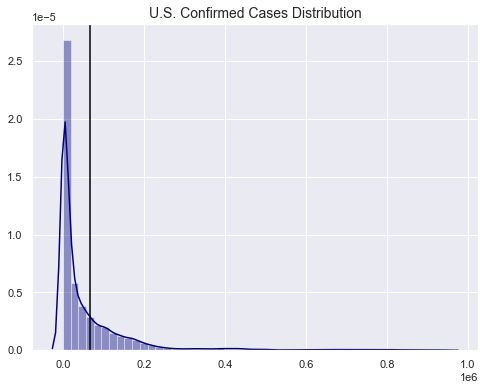

In [189]:
plt.figure(figsize=(8, 6))
sns.distplot(open_data['confirmed_cases'], color = 'navy', bins = 50)
plt.axvline(np.mean(open_data['confirmed_cases']), color='black')
plt.xlabel('')
plt.title('U.S. Confirmed Cases Distribution', size=14);

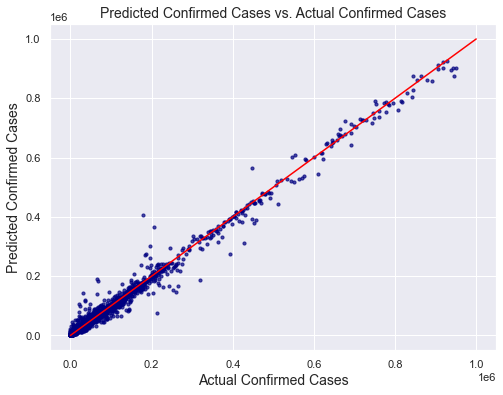

In [190]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, color = 'navy', alpha=0.7, s=10)
plt.plot((0, 1_000_000), (0, 1_000_000), color='red')
plt.xlabel('Actual Confirmed Cases', size=14)
plt.title('Predicted Confirmed Cases vs. Actual Confirmed Cases', size=14)
plt.ylabel('Predicted Confirmed Cases', size=14);

In [191]:
resids = y_test - y_test

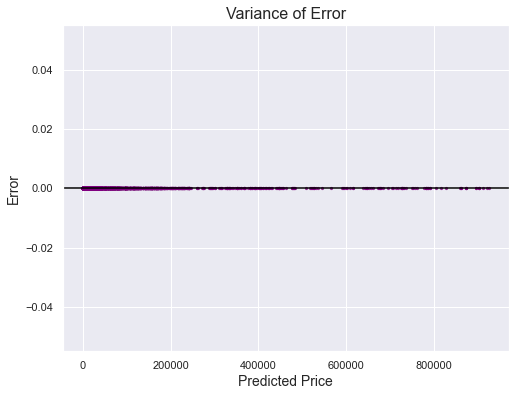

In [192]:
# Construct a plot of predicted price vs. error (for test data)
plt.figure(figsize=(8,6))
plt.scatter(y_test_pred, resids, color = 'purple', alpha=0.7, s=5)
plt.axhline(0, color='black')
plt.title('Variance of Error', size = 16)
plt.xlabel('Predicted Price', size=14)
plt.ylabel('Error', size=14);

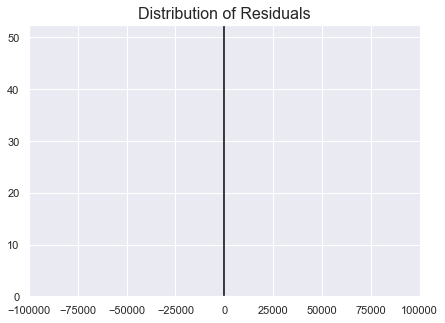

In [193]:
plt.figure(figsize=(7,5))
sns.distplot(resids, color='grey')
plt.axvline(0, color='black')
plt.xlim(-100_000, 100_000)
plt.title('Distribution of Residuals', size=16)
plt.xlabel("");

### Symptoms

In [196]:
symptoms_merge_2_dummies=pd.get_dummies(symptoms_merge_2,columns=['state'],drop_first=True)
symptoms_merge_2_dummies.fillna(0,inplace=True)

In [197]:
X=symptoms_merge_2_dummies.drop(columns=['date_x','deaths','month','day','confirmed_cases'])
y=symptoms_merge_2_dummies['confirmed_cases']

In [198]:
X_train,X_test,y_train,y_test= train_test_split(X,y)

#### Linear Regression

In [199]:
lr=LinearRegression()
ss=StandardScaler()

In [200]:
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.transform(X_test)
lr.fit(X_train_s,y_train)
lr.score(X_train_s,y_train),lr.score(X_test_s,y_test)

(0.7373156039190335, 0.69923074309053)

#### Ridge

In [201]:
from sklearn.linear_model import Ridge

In [202]:
ridge = Ridge(alpha=10)
ridge.fit(X_train_s, y_train)   
print('Training score:', ridge.score(X_train_s, y_train))
print('Test score:', ridge.score(X_test_s, y_test))

Training score: 0.7373002914176445
Test score: 0.6994024117875178


#### RidgeCV

In [203]:
from sklearn.linear_model import RidgeCV
r_alphas = np.logspace(0, 5, 100)
r_alphas
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_cv.fit(X_train_s, y_train);
# optimal alpha from range
ridge_cv.alpha_
# Instantiate.
ridge_model = Ridge(alpha=1.1233240329780274)
ridge_model.fit(X_train_s, y_train)   
print('Training score:', ridge_cv.score(X_train_s, y_train))
print('Test score:', ridge_cv.score(X_test_s, y_test))

Training score: 0.7366649141122903
Test score: 0.6999172734980419


#### Lasso

In [204]:
from sklearn.linear_model import LassoCV
l_alpha = np.logspace(-3, 0, 100)
lasso_cv = LassoCV(alphas=l_alpha, cv=5, max_iter=50000)
lasso_cv.fit(X_train_s, y_train)
print(lasso_cv.score(X_train_s, y_train))
print(lasso_cv.score(X_test_s, y_test))

0.7373154883571427
0.6992400323397229


#### RandomForest

In [205]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train_s, y_train)
params = {'n_estimators': [1, 10, 50, 100], 
         'max_depth': [None,1, 2, 3],
         'max_features':['auto', None]}
gs = GridSearchCV(rf, param_grid=params)
gs.fit(X_train_s, y_train)
print('Random Forest training score:', gs.score(X_train_s, y_train))
print('Random Forest testing score:', gs.score(X_test_s, y_test))

Random Forest training score: 0.9946425021403307
Random Forest testing score: 0.9682806327359889


In [206]:
gs.best_params_

{'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

In [207]:
gs.best_score_

0.9554694910475827

### MASK

#### County

In [208]:
mask_county=pd.read_csv('mask_county.csv')

mask_county=mask_county.drop(columns='Unnamed: 0')

mask_county.head()

county_name  total_pop  confirmed_cases  deaths  never  rarely  \
0  Baldwin County   218022.0             7348      84  0.083   0.059   
1  Calhoun County   114277.0             5254      68  0.152   0.108   
2  Cullman County    83442.0             3328      29  0.130   0.024   
3   DeKalb County    71385.0             3942      34  0.084   0.051   
4   Elmore County    81887.0             3495      60  0.042   0.095   

   sometimes  frequently  always  
0      0.098       0.323   0.436  
1      0.130       0.167   0.442  
2      0.249       0.217   0.379  
3      0.106       0.179   0.580  
4      0.127       0.252   0.485

In [209]:
mask_county['deaths_per_person']=mask_county['deaths']/mask_county['total_pop']
mask_county['infection_rate']=mask_county['confirmed_cases']/mask_county['total_pop']
mask_county['deaths_per_case']=mask_county['deaths']/mask_county['confirmed_cases']

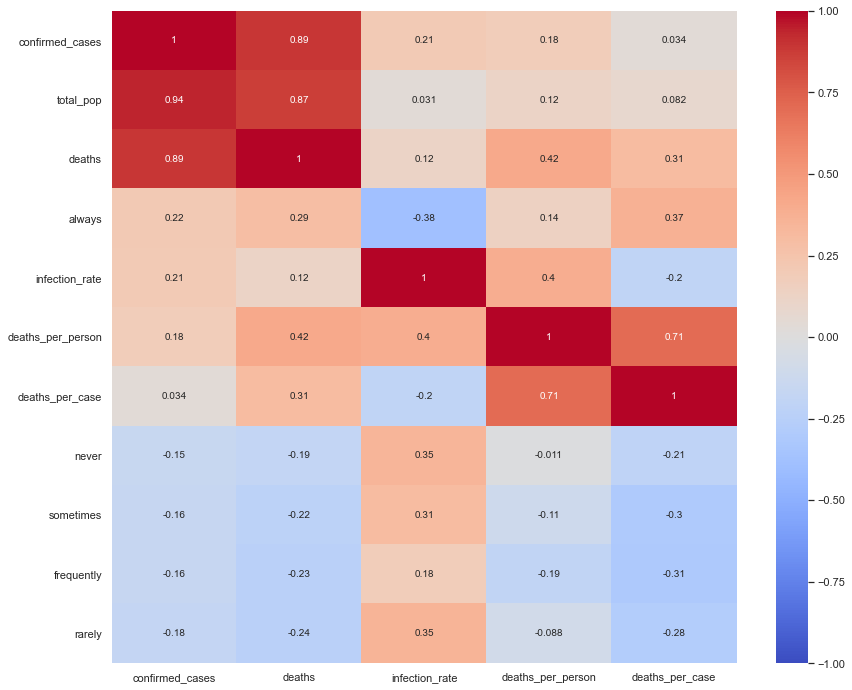

In [210]:
plt.figure(figsize=(14,12))
sns.heatmap(mask_county.corr()[['confirmed_cases','deaths','infection_rate','deaths_per_person','deaths_per_case']].sort_values(by='confirmed_cases', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1);

In [211]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [212]:
mask_county.head()

county_name  total_pop  confirmed_cases  deaths  never  rarely  \
0  Baldwin County   218022.0             7348      84  0.083   0.059   
1  Calhoun County   114277.0             5254      68  0.152   0.108   
2  Cullman County    83442.0             3328      29  0.130   0.024   
3   DeKalb County    71385.0             3942      34  0.084   0.051   
4   Elmore County    81887.0             3495      60  0.042   0.095   

   sometimes  frequently  always  deaths_per_person  infection_rate  \
0      0.098       0.323   0.436           0.000385        0.033703   
1      0.130       0.167   0.442           0.000595        0.045976   
2      0.249       0.217   0.379           0.000348        0.039884   
3      0.106       0.179   0.580           0.000476        0.055222   
4      0.127       0.252   0.485           0.000733        0.042681   

   deaths_per_case  
0         0.011432  
1         0.012943  
2         0.008714  
3         0.008625  
4         0.017167

In [213]:
mask_county=pd.get_dummies(mask_county,columns=['county_name'],drop_first=True)

In [214]:
X=mask_county.drop(columns=['infection_rate','confirmed_cases','deaths','deaths_per_person','deaths_per_case','total_pop'])
y=np.log(mask_county['confirmed_cases'])

In [215]:
X_train,X_test,y_train,y_test= train_test_split(X,y)

In [216]:
lr=LinearRegression()
ss=StandardScaler()
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.transform(X_test)
lr.fit(X_train_s,y_train)
lr.score(X_train_s,y_train),lr.score(X_test_s,y_test)

(0.7954579937343377, -1.0431508054353774e+26)

In [217]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)
ridge.fit(X_train_s, y_train)   
print('Training score:', ridge.score(X_train_s, y_train))
print('Test score:', ridge.score(X_test_s, y_test))

Training score: 0.8232902681194976
Test score: -0.14779577762553564


In [218]:
from sklearn.linear_model import RidgeCV
r_alphas = np.logspace(0, 5, 100)
r_alphas
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_cv.fit(X_train_s, y_train);
# optimal alpha from range
ridge_cv.alpha_
# Instantiate.
ridge_model = Ridge(alpha=1.1233240329780274)
ridge_model.fit(X_train_s, y_train)   
print('Training score:', ridge_cv.score(X_train_s, y_train))
print('Test score:', ridge_cv.score(X_test_s, y_test))

Training score: 0.4458705879221001
Test score: -0.0014361155051145769


In [219]:
from sklearn.linear_model import Lasso, LassoCV

l_alpha = np.logspace(-3, 0, 100)
lasso_cv = LassoCV(alphas=l_alpha, cv=5, max_iter=50000)
lasso_cv.fit(X_train_s, y_train);

print(lasso_cv.score(X_train_s, y_train))
print(lasso_cv.score(X_test_s, y_test))

0.19106359753525914
-0.0053248506548744245


In [220]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

params = {'n_estimators': [1, 10, 50, 100], 
         'max_depth': [None,1, 2, 3],
         'max_features':['auto', None]}
gs = GridSearchCV(rf, param_grid=params)
gs.fit(X_train_s, y_train)
print('Random Forest training score:', gs.score(X_train_s, y_train))
print('Random Forest testing score:', gs.score(X_test_s, y_test))

Random Forest training score: 0.8909980578467654
Random Forest testing score: 0.0535570729190481


In [221]:
from sklearn.ensemble import ExtraTreesRegressor
et=ExtraTreesRegressor()
params = {'n_estimators': [1, 10, 50, 100], 
         'max_depth': [None,1, 2, 3],
         'max_features':['auto', None]}
gs = GridSearchCV(et, param_grid=params)
gs.fit(X_train_s, y_train)
print('Random Forest training score:', gs.score(X_train_s, y_train))
print('Random Forest testing score:', gs.score(X_test_s, y_test))

Random Forest training score: 1.0
Random Forest testing score: 0.026431814138836218


## Results

### Open Data (Merged Open Data w/ Policy and Mobility Datasets)

In [194]:
covid_models_data = {
    'Prinicipal_comp_reg': [round(rf.score(Z_train, y_train),4), round(rf.score(Z_test, y_test),4),],
    'Random_Forest_Regres': [ round(gs.score(X_train_s, y_train),4), round(gs.score(X_test_s, y_test), 4)],
    'Lasso': [round(lasso_cv.score(X_train_s, y_train),4),  round(lasso_cv.score(X_test_s, y_test),4)],
    'Ridge': [round(ridge_model.score(X_train_s, y_train),4),  round(ridge_model.score(X_test_s, y_test),4)],
    'Linear_Regression': [round(mls.score(X_train_s, y_train), 4), round(mls.score(X_test_s, y_test), 4)], 
    'ENET': [round(enet_model.score(X_train_s, y_train),4), enet_model.score(X_test_s, y_test)]
}

In [195]:
covid_models = pd.DataFrame.from_dict(covid_models_data, orient='index',
                                         columns = ['Training r2 Score', 'Test r2 Score'])
covid_models

Training r2 Score  Test r2 Score
Prinicipal_comp_reg              0.9909       0.917500
Random_Forest_Regres             0.9979       0.988600
Lasso                            0.6817       0.654500
Ridge                            0.6812       0.654200
Linear_Regression                0.6819       0.654500
ENET                             0.6425       0.615183

### Symptoms

|       Model       | Training Score | Test Score |
|:-----------------:|----------------|------------|
| Linear Regression | 0.733689       | 0.718972   |
| Ridge             | 0.733673       | 0.719133   |
| RidgeCV           | 0.733269       | 0.719450   |
| Lasso             | 0.733689       | 0.718990   |
| Random Forest     | 0.994890       | 0.969984   |

### Mask County

|       Model       | Training Score | Test Score |
|:-----------------:|----------------|------------|
| Linear Regression | 0.648969       | -3.535922  |
| Ridge             | 0.922133       | 0.344883   |
| RidgeCV           | 0.911987       | 0.333114   |
| Lasso             | 0.401339       | 0.449235   |
| Random Forest     | 0.965044       |  0.776316  |
| Extra Tree        | 1.0            | 0.785858   |

## Conclusions

In conclusion, we created a multiple regression models (Linear Regression, Lasso Regression, Ridge, Elastic Net, Principle Component Regression, Extra Tree). The best performance for all our data sets was through Random Forest Regression modeling. 

The R2 score for Open Data testing data was around .989, therefore accounting for 98.9% of the variability in testing data. The Root Mean Square Error of the model was right at 5,649. Therefore, the model can accurately predict confirmed cases by state within 5,649 cases, important to note when looking at future predicted cases based off of this model.

For the symptoms dataset, we found that compared to last year, the top 5 google search symptoms were infection, common cold, fever, acne, and xeroderma. Behavioral symptoms were the most highly correlated with covid case count (ex. dysphoria, anxiety, depression). We were able to create a random forest model just on google symptom search date with a test score R2 of .969.  

In the mask data, we could not find a strong correlation between mask usage and covid case count. All the models overfit the training data and produced poor testing scores. 
